In [23]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
dados = pd.read_csv('dados/sales_train.csv')

In [18]:
item_cat = pd.read_csv("dados/item_categories.csv")
item = pd.read_csv("dados/items.csv")
sub = pd.read_csv("dados/sample_submission.csv")
shops = pd.read_csv("dados/shops.csv")
test = pd.read_csv("dados/test.csv")

In [12]:
dados.head()

,data,mes_consecutivo,loja_id,item_id,preco_item,venda_item_dia
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
dados.data = dados.data.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
data               datetime64[ns]
mes_consecutivo    int64
loja_id            int64
item_id            int64
preco_item         float64
venda_item_dia     float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [14]:
mes_vendas = dados.groupby(["mes_consecutivo","loja_id","item_id"])[
    "data","preco_item","venda_item_dia"].agg({"data":["min",'max'],"preco_item":"mean","venda_item_dia":"sum"})

In [16]:
mes_vendas.head(20)

data            preco_item  \
                                       min        max       mean   
mes_consecutivo loja_id item_id                                    
0               0       32      2013-01-03 2013-01-31      221.0   
                        33      2013-01-03 2013-01-28      347.0   
                        35      2013-01-31 2013-01-31      247.0   
                        43      2013-01-31 2013-01-31      221.0   
                        51      2013-01-13 2013-01-31      128.5   
                        61      2013-01-10 2013-01-10      195.0   
                        75      2013-01-17 2013-01-17       76.0   
                        88      2013-01-16 2013-01-16       76.0   
                        95      2013-01-06 2013-01-06      193.0   
                        96      2013-01-10 2013-01-10       70.0   
                        98      2013-01-04 2013-01-31      268.0   
                        111     2013-01-17 2013-01-17       89.0   
                        149     2013-01-11 2013-01-28       99.0   
                        151     2013-01-16 2013-01-16       75.0   
                        153     2013-01-09 2013-01-09      258.0   
                        198     2013-01-10 2013-01-10      112.0   
                        210     2013-01-05 2013-01-25      118.0   
                        282     2013-01-04 2013-01-04      109.0   
                        306     2013-01-22 2013-01-22       59.0   
                        351     2013-01-21 2013-01-21       89.0   

                                venda_item_dia  
                                           sum  
mes_consecutivo loja_id item_id                 
0               0       32                 6.0  
                        33                 3.0  
                        35                 1.0  
                        43                 1.0  
                        51                 2.0  
                        61                 1.0  
                        75                 1.0  
                        88                 1.0  
                        95                 1.0  
                        96                 1.0  
                        98                25.0  
                        111                1.0  
                        149                3.0  
                        151                1.0  
                        153                1.0  
                        198                1.0  
                        210                2.0  
                        282                1.0  
                        306                1.0  
                        351                1.0

In [19]:
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


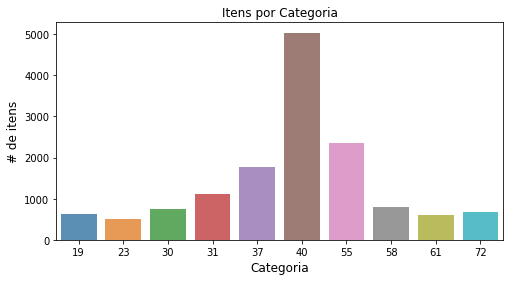

In [24]:
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Itens por Categoria")
plt.ylabel('# de itens', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.show()

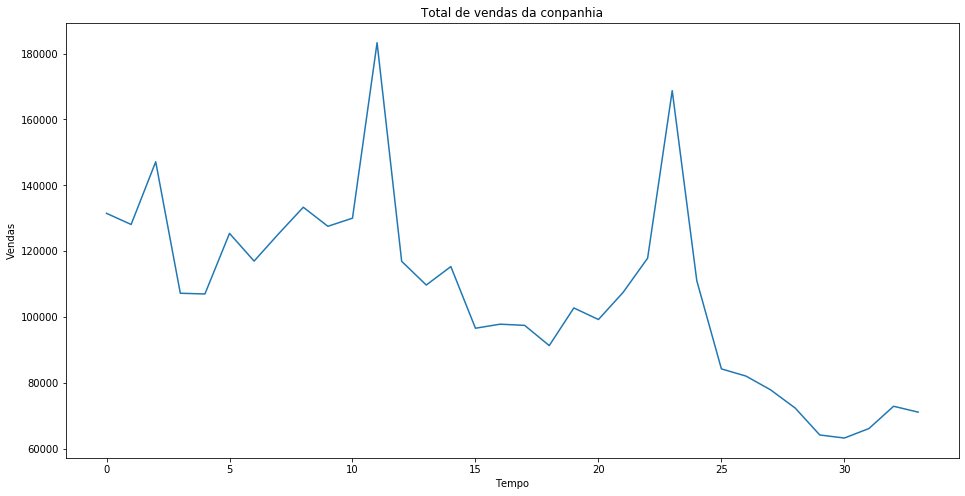

In [25]:
ts=dados.groupby(["mes_consecutivo"])["venda_item_dia"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total de vendas da conpanhia')
plt.xlabel('Tempo')
plt.ylabel('Vendas')
plt.plot(ts)

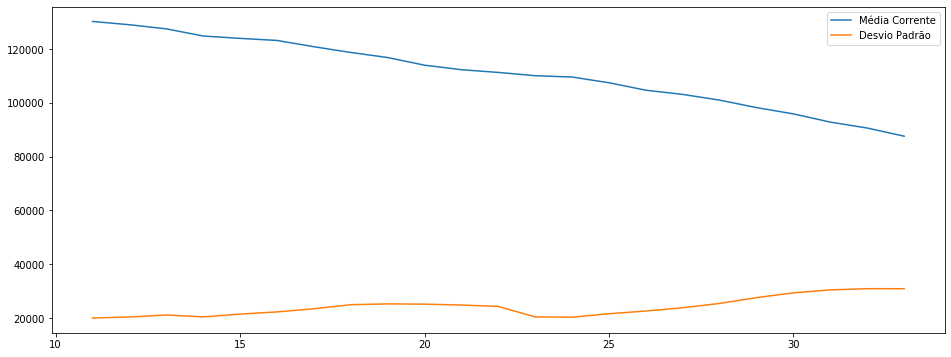

In [26]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Média Corrente');
plt.plot(ts.rolling(window=12,center=False).std(),label='Desvio Padrão');
plt.legend();

## Libs pra trabalhar com times series

In [28]:
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\samusilv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


<Figure size 1152x864 with 0 Axes>

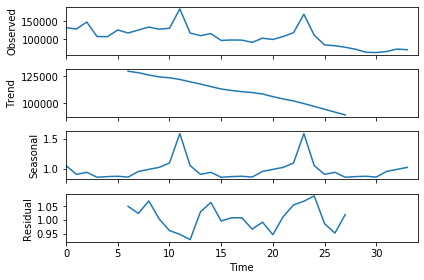

In [29]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()

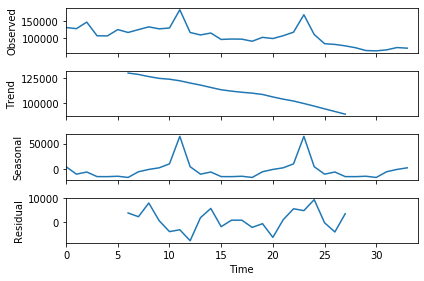

In [30]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

In [31]:
def teste_stacionaridade(timeseries):
    
    #Executando teste Dickey-Fuller
    print('Resultados do teste de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste Statistico','p-value','#Lags Used','Numero de Observações Usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valores Criticos (%s)'%key] = value
    print (dfoutput)

teste_stacionaridade(ts)

Resultados do teste de Dickey-Fuller:
Teste Statistico                -2.395704
p-value                          0.142953
#Lags Used                       0.000000
Numero de Observações Usadas    33.000000
Valores Criticos (1%)           -3.646135
Valores Criticos (5%)           -2.954127
Valores Criticos (10%)          -2.615968
dtype: float64


In [32]:
from pandas import Series as Series

In [33]:
#Criando serie deiferenciada
def differenca(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


#inverter previsão diferenciada
def inverse_difference(last_ob, value):
    return value + last_ob

[]

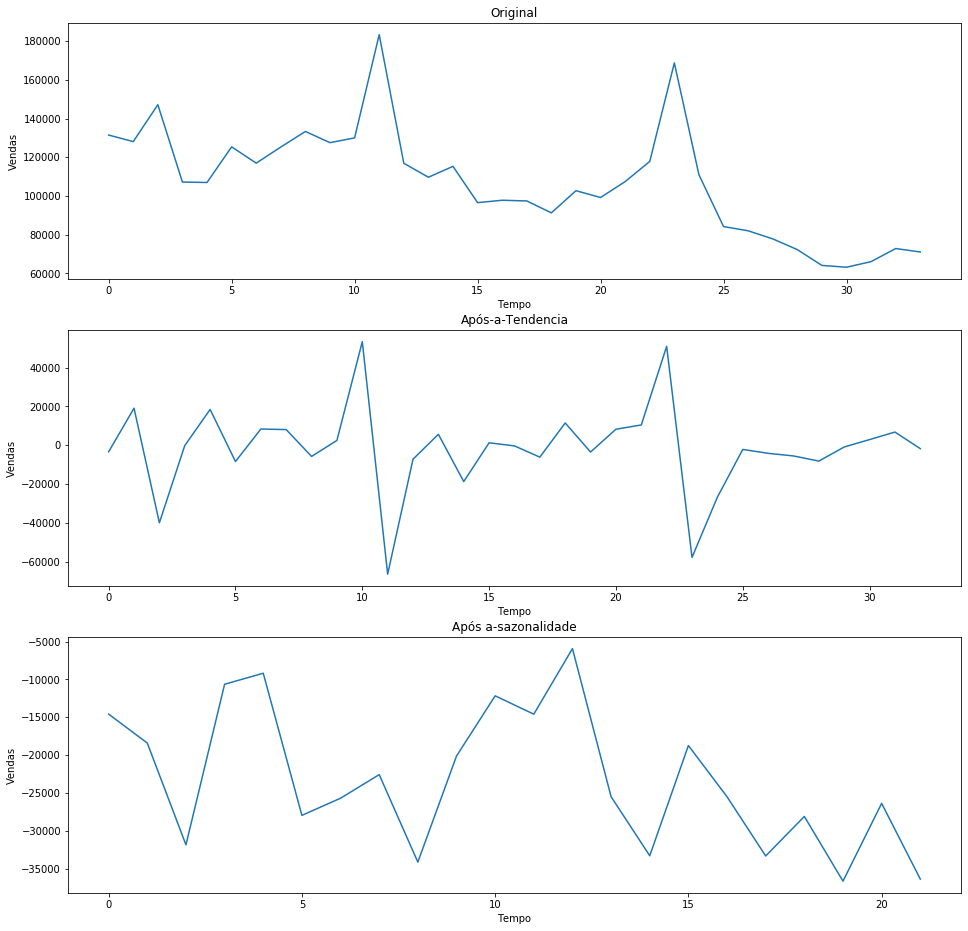

In [41]:
ts = dados.groupby(["mes_consecutivo"])["venda_item_dia"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Tempo')
plt.ylabel('Vendas')
plt.plot(ts)
plt.subplot(312)
plt.title('Após-a-Tendencia')
plt.xlabel('Tempo')
plt.ylabel('Vendas')
novo_ts=differenca(ts)
plt.plot(novo_ts)
plt.plot()

plt.subplot(313)
plt.title('Após a-sazonalidade')
plt.xlabel('Tempo')
plt.ylabel('Vendas')
novo_ts=differenca(ts,12)       # assuming the seasonality is 12 months long
plt.plot(novo_ts)
plt.plot()

In [42]:
teste_stacionaridade(novo_ts)

Resultados do teste de Dickey-Fuller:
Teste Statistico                -3.270101
p-value                          0.016269
#Lags Used                       0.000000
Numero de Observações Usadas    21.000000
Valores Criticos (1%)           -3.788386
Valores Criticos (5%)           -3.013098
Valores Criticos (10%)          -2.646397
dtype: float64


In [43]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [44]:
import numpy as np

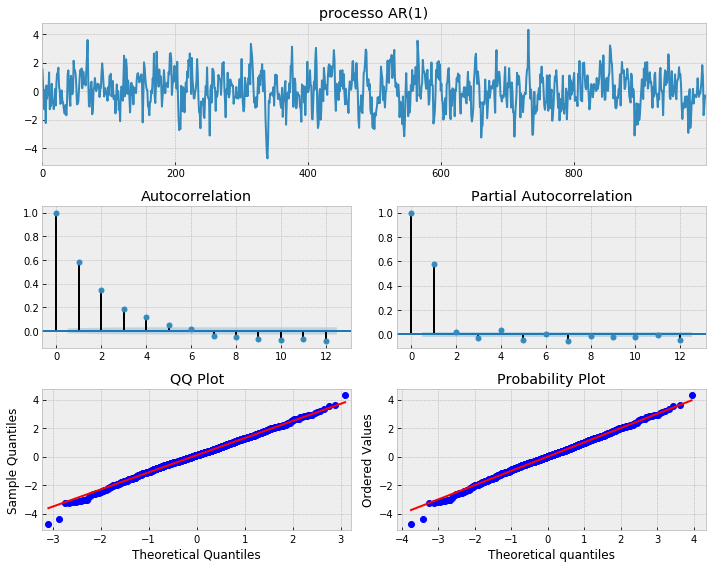

In [45]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="processo AR(1)")

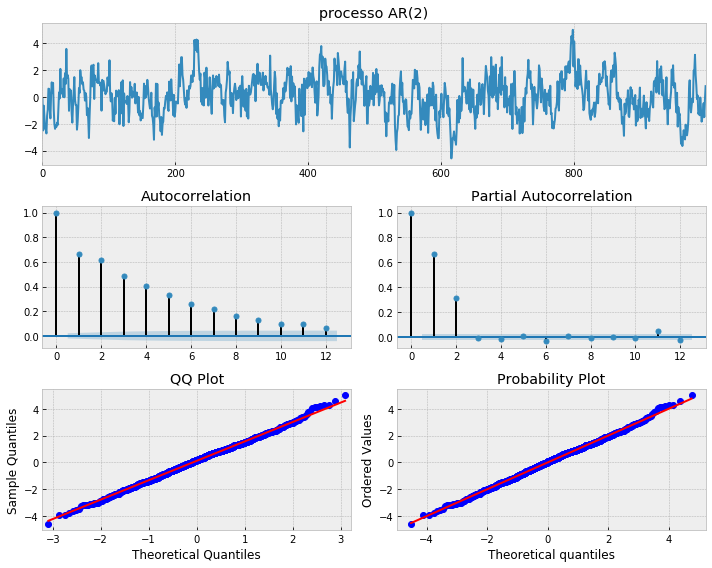

In [47]:
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]


ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="processo AR(2)")

In [50]:
ts = dados.groupby(["mes_consecutivo"])["venda_item_dia"].sum()
ts.index = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts = ts.reset_index()
ts.head(10)

,index,venda_item_dia
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0
5,2013-06-01,125381.0
6,2013-07-01,116966.0
7,2013-08-01,125291.0
8,2013-09-01,133332.0
9,2013-10-01,127541.0


In [51]:
ts.to_csv('dados/ts.csv', index=False)